# Python自动化运维基础

## 1. 一个简单的轮子：服务器性能监控器(node-monitor)

### 1.1 设计需求

大数据时代，企业的运维人员的工作量越来越大，对于非互联网公司，实现一个远程自动化的监控工具是很有必要的，可以省去大量手动运维的时间，提高运维效率。

### 1.2 开发环境

#### 语言:python3.6+

#### 用到的模块

- paramiko (linux ssh模块)
- smtplib（邮件发送模块）
- APScheduler (定时任务模块)
- psutil*（系统性能信息模块）

### 1.3 实验环境

#### 基于Docker虚拟化容器技术的分布式集群

为了模拟真实的运维场景，本实验使用当前虚拟化和运维领域最火红的Docker容器技术来构建虚拟化网络环境。Docker + Kubernetes（K8S）将是未来云计算的主流，也是大数据平台建设首选技术，不管是运维人员还是开发人员，都应该好好学习一下。关于Docker的安装和使用，大家可以参考以下资料：

##### Docker参考资料

- Docker官网：https://www.docker.com
- 菜鸟教程：https://www.runoob.com/docker/docker-tutorial.html
- Github Docker源码：https://github.com/docker/docker-ce
- 在线图书《Docker入门到实践》：https://docker_practice.gitee.io/zh-cn/
- 在线图书《从Docker到Kubernetes进阶》：https://www.qikqiak.com/k8s-book

如果大家的Windows系统无法安装Docker，或者安装困难，有以下三种实验方案可供选择：

##### 实验方案

- 安装虚拟机软件（如VMware和VirtualBox)，然后在虚拟机上安装linux系统（Ubuntu或CentOS)，在linux虚拟机环境中安装Docker来进行实验
- 购买云主机（腾讯云、阿里云和华为云），然后在云主机中安装Docker来进行实验
- 安装虚拟机软件，通过运行多个linux虚拟机实例来模拟网络集群环境。为了便于管理虚拟机实例，建议大家用Vagrant+Virtualbox，通过它我们可以很快速的建立开发和测试的虚拟环境。

##### 虚拟网络结构

本实验的虚拟网络结构如下图所示，其中Server1 ~ Server3为被监控的目标节点（Managed node)，即被控端。运维人员通过主控端（Control Machine）对目标节点实施监控，每个节点对应一个Docker容器，通过运行不同的镜像来模拟不同的linux操作系统环境及软件系统，被监控的目标节点分别运行Ubuntu16.4+SSHD、Debian8+SSHD和CentOS7+SSHD系统。为了便于进行探索式编程，并记录详细操作步骤，监控机运行Ubuntu20.4 + JupyterLab。

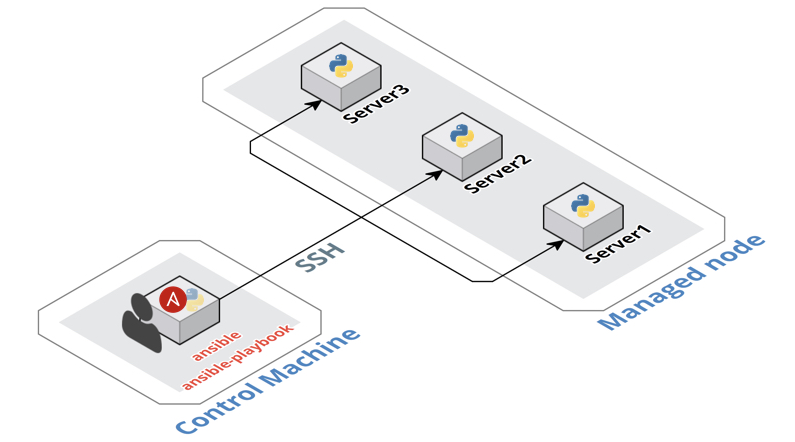

这里强烈建议大家合伙购买云主机，这套实验环境在云主机上通过Docker部署好之后，自己的电脑上无需安装任何软件，用浏览器就能完成所有大数据课程的实验。如果公司有公网可访问的服务器，那就更好了。

### 1.4 实现过程

#### paramiko的使用

Paramiko是一个基于SSHv2协议的Python实现，提供客户端和服务器的功能。使用Paramiko可以方便地通过SSH协议执行远程主机的程序或脚本，获取输出结果和返回值。Paramiko是免agent的，即远程主机只需运行SSHD后台服务器进程即可，而大部分支持远程运维的linux服务器都默认运行SSHD。

##### （1）安装paramiko库!

In [4]:
pip install paramiko -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
  Using cached https://mirrors.aliyun.com/pypi/packages/06/1e/1e08baaaf6c3d3df1459fd85f0e7d2d6aa916f33958f151ee1ecc9800971/paramiko-2.7.1-py2.py3-none-any.whl (206 kB)
  Using cached https://mirrors.aliyun.com/pypi/packages/8b/1d/82826443777dd4a624e38a08957b975e75df859b381ae302cfd7a30783ed/bcrypt-3.1.7-cp34-abi3-manylinux1_x86_64.whl (56 kB)
  Using cached https://mirrors.aliyun.com/pypi/packages/9d/57/2f5e6226a674b2bcb6db531e8b383079b678df5b10cdaa610d6cf20d77ba/PyNaCl-1.4.0-cp35-abi3-manylinux1_x86_64.whl (961 kB)
Note: you may need to restart the kernel to use updated packages.


##### （2）基本用法

In [2]:
import paramiko

In [3]:
client = paramiko.SSHClient()

In [4]:
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

In [31]:
server_cfgs = [
    {'name': 'node-ubuntu', 'username': 'docker', 'password': 'docker'},
    {'name': 'node-debian', 'username': 'docker', 'password': 'docker'},
    {'name': 'node-centos', 'username': 'docker', 'password': 'docker'}
]

In [59]:
for server_cfg in server_cfgs:
    # 使用密码连接服务器（不安全）
    client.connect(server_cfg['name'], 22, 
                   username=server_cfg['username'], 
                   password=server_cfg['password'], 
                   timeout=4)
    # 远程执行shell命令
    stdin, stdout, stderr = client.exec_command("free -h")
    # 输出远程服务器shell命令的输出
    stdout_str = stdout.read().decode('utf-8')
    # 获取返回的状态码
    ret_code = stdout.channel.recv_exit_status()
    print("******** {} 内存状态, 状态码：{} ********\n{}".format(server_cfg['name'], ret_code, stdout_str))
    # 关闭连接
    client.close()

******** node-ubuntu 内存状态, 状态码：0 ********
              total        used        free      shared  buff/cache   available
Mem:          1.9Gi       488Mi       267Mi       0.0Ki       1.2Gi       1.3Gi
Swap:         1.0Gi       149Mi       874Mi

******** node-debian 内存状态, 状态码：0 ********
             total       used       free     shared    buffers     cached
Mem:          1.9G       1.7G       266M       816K       165M       827M
-/+ buffers/cache:       731M       1.2G
Swap:         1.0G       149M       874M

******** node-centos 内存状态, 状态码：0 ********
              total        used        free      shared  buff/cache   available
Mem:           1.9G        489M        265M        816K        1.2G        1.3G
Swap:          1.0G        149M        874M



##### （3）通过Transport

In [61]:
import paramiko
 
transport = paramiko.Transport(('node-ubuntu', 22))
transport.connect(username='docker', password='docker')
 
ssh = paramiko.SSHClient()
ssh._transport = transport
 
stdin, stdout, stderr = ssh.exec_command('df -Th')
print('-' * 20, '服务器硬盘空间状态', '-' * 20)
print(stdout.read().decode('utf-8'))
 
transport.close()

-------------------- 服务器硬盘空间状态 --------------------
Filesystem     Type     Size  Used Avail Use% Mounted on
overlay        overlay   59G   13G   43G  24% /
tmpfs          tmpfs     64M     0   64M   0% /dev
tmpfs          tmpfs    996M     0  996M   0% /sys/fs/cgroup
/dev/vda1      ext4      59G   13G   43G  24% /etc/hosts
shm            tmpfs     64M     0   64M   0% /dev/shm
tmpfs          tmpfs    996M     0  996M   0% /proc/acpi
tmpfs          tmpfs    996M     0  996M   0% /sys/firmware



##### （4）基于公钥（免密）和的两种连接方式

- 使用SSHClient直接连接

In [63]:
import paramiko

# 指定私钥文件
private_key = paramiko.RSAKey.from_private_key_file('.ssh/id_rsa')
 
# 创建SSH客户端对象
ssh = paramiko.SSHClient()
# 允许连接不在know_hosts文件中的主机
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
# 连接服务器
ssh.connect(hostname='node-centos', port=22, username='docker', pkey=private_key)
 
# 执行命令
stdin, stdout, stderr = ssh.exec_command('vmstat 2 3')
# 获取命令结果
result = stdout.read().decode('utf-8')
print('=' * 31, '服务器虚拟内存状态', '=' * 31)
print(result)
 
# 关闭连接
ssh.close()

=============================== 服务器虚拟内存状态 ===============================
procs -----------memory---------- ---swap-- -----io---- -system-- ------cpu-----
 r  b   swpd   free   buff  cache   si   so    bi    bo   in   cs us sy id wa st
 2  0 152832 238760 170080 1098616    1    2    11    39   58   92  2  2 96  0  0
 0  0 152832 238704 170080 1098624    0    0     0     0  360  727  1  2 98  0  0
 0  0 152832 238704 170080 1098624    0    0     0     0  364  761  1  1 98  0  0



- 使用Transport连接

In [68]:
import paramiko
 
private_key = paramiko.RSAKey.from_private_key_file('.ssh/id_rsa')
 
transport = paramiko.Transport(('node-debian', 22))
transport.connect(username='docker', pkey=private_key)
 
ssh = paramiko.SSHClient()
ssh._transport = transport

stdin, stdout, stderr = ssh.exec_command("df |sed -e 's/%//'|awk '$5>10{print $0}'")

print('-' * 20, '使用率超过10%的卷', '-' * 20)
print(stdout.read().decode('utf-8'))
 
transport.close()

-------------------- 使用率超过10%的卷 --------------------
Filesystem     1K-blocks     Used Available Use Mounted on
overlay         61255492 13582960  44531208  24 /
/dev/vda1       61255492 13582960  44531208  24 /etc/hosts



##### （5）使用TFTPClient进行文件的上传与下载

- 基于用户名和密码的上传与下载

In [56]:
import paramiko
 
transport = paramiko.Transport(('node-ubuntu',22))
transport.connect(username='docker',password='docker')
 
sftp = paramiko.SFTPClient.from_transport(transport)
 
# 将本地rc.sh文件上传至服务器 /tmp/test.sh
sftp.put('rc.sh', '/tmp/test.sh')
 
# 将服务器/home/docker/lsout.txt下载到本地
sftp.get('/home/docker/lsout.txt', './lsout.txt')
 
transport.close()

In [57]:
!cat lsout.txt

total 100
drwxr-xr-x   1 root root 4096 Jul 28 09:46 bin
drwxr-xr-x   2 root root 4096 Apr 12  2016 boot
drwxr-xr-x   5 root root  340 Jul 28 08:34 dev
drwxr-xr-x   1 root root 4096 Jul 28 13:32 etc
drwxr-xr-x   1 root root 4096 Nov 14  2019 home
drwxr-xr-x   1 root root 4096 Jul 28 09:49 lib
drwxr-xr-x   1 root root 4096 Jul 28 09:45 lib64
drwxr-xr-x   2 root root 4096 Oct 24  2019 media
drwxr-xr-x   2 root root 4096 Oct 24  2019 mnt
drwxr-xr-x   2 root root 4096 Oct 24  2019 opt
dr-xr-xr-x 182 root root    0 Jul 28 08:34 proc
drwx------   1 root root 4096 Jul 28 11:13 root
drwxr-xr-x   1 root root 4096 Jul 29 05:06 run
drwxr-xr-x   1 root root 4096 Jul 28 09:49 sbin
drwxr-xr-x   2 root root 4096 Oct 24  2019 srv
dr-xr-xr-x  12 root root    0 Jul 28 08:34 sys
drwxrwxrwt   1 root root 4096 Jul 28 13:44 tmp
drwxr-xr-x   1 root root 4096 Oct 24  2019 usr
drwxr-xr-x   1 root root 4096 Oct 24  2019 var


- 基于公钥的上传与下载

In [54]:
import paramiko
 
private_key = paramiko.RSAKey.from_private_key_file('.ssh/id_rsa')
 
transport = paramiko.Transport(('node-centos',22))
transport.connect(username='docker',password='docker')
 
sftp = paramiko.SFTPClient.from_transport(transport)
 
# 将本地rc.sh文件上传至服务器 /tmp/test.sh
sftp.put('rc.sh', '/tmp/test.sh')
 
# 将服务器/home/docker/lsout.txt下载到本地
sftp.get('/etc/os-release', './centos.txt')
 
transport.close()

In [58]:
!cat centos.txt

NAME="CentOS Linux"
VERSION="7 (Core)"
ID="centos"
ID_LIKE="rhel fedora"
VERSION_ID="7"
PRETTY_NAME="CentOS Linux 7 (Core)"
ANSI_COLOR="0;31"
CPE_NAME="cpe:/o:centos:centos:7"
HOME_URL="https://www.centos.org/"
BUG_REPORT_URL="https://bugs.centos.org/"

CENTOS_MANTISBT_PROJECT="CentOS-7"
CENTOS_MANTISBT_PROJECT_VERSION="7"
REDHAT_SUPPORT_PRODUCT="centos"
REDHAT_SUPPORT_PRODUCT_VERSION="7"



##### （5）paromiko实例-堡垒机pyshell

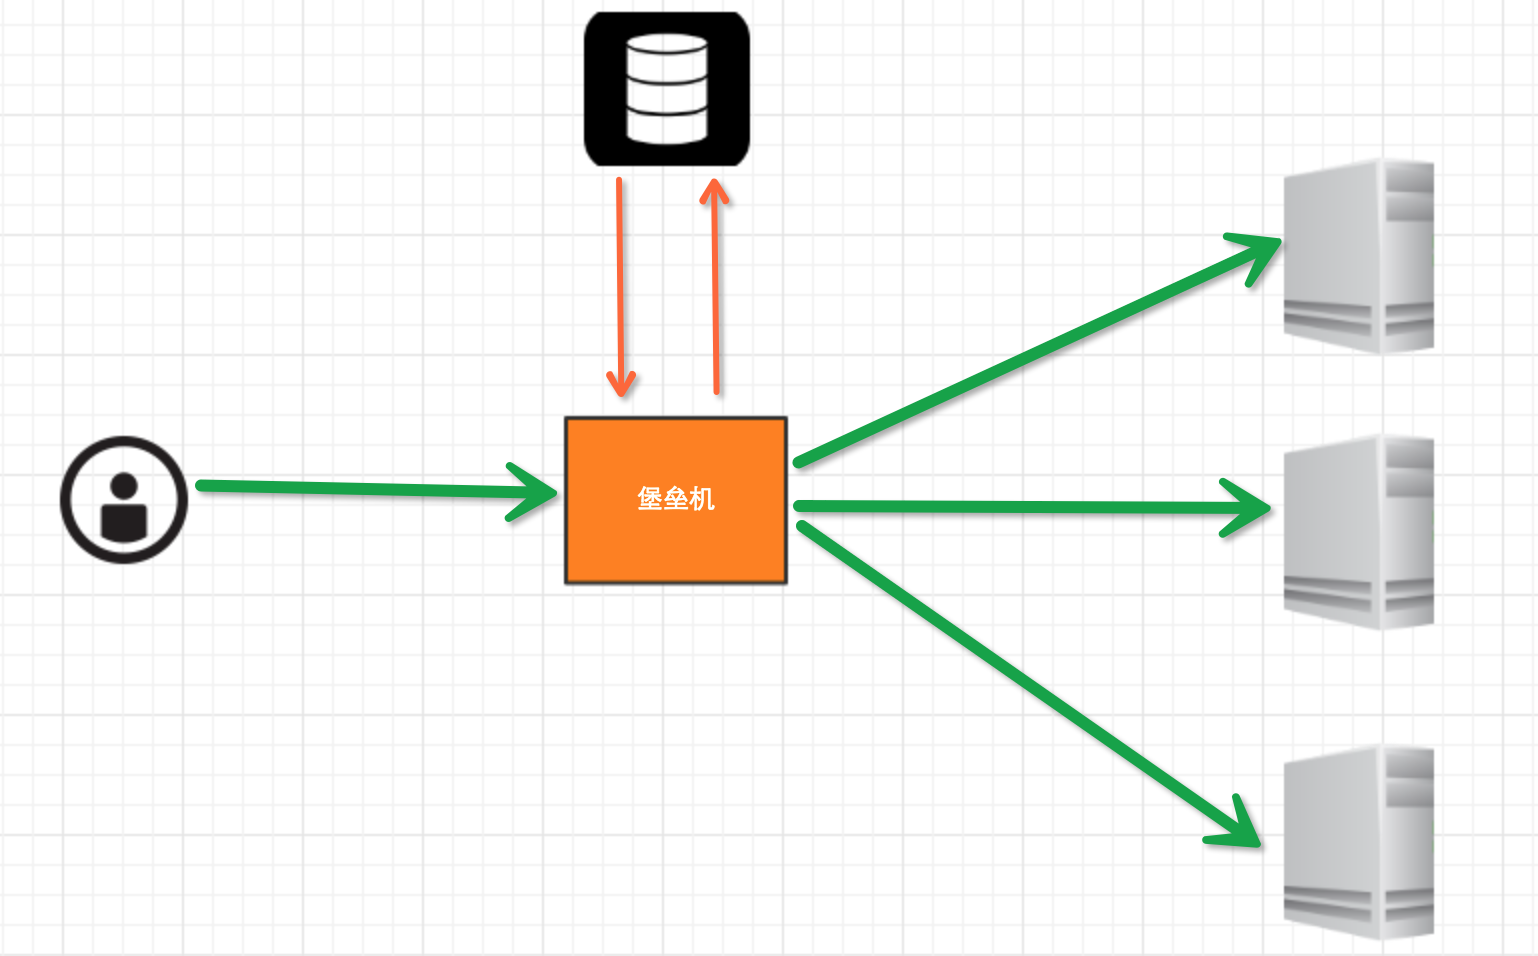

堡垒机执行流程：

- 管理员为用户在服务器上创建账号（将公钥放置服务器，或者使用用户名密码）
- 用户登陆堡垒机，输入堡垒机用户名密码，现实当前用户管理的服务器列表
- 用户选择服务器，并自动登陆
- 执行操作并同时将用户操作记录

代码实现：

In [69]:
!cat pyshell/pyshell.py

import paramiko
import sys
import os
import socket
import getpass
 
from paramiko.py3compat import u
 
# windows不支持termios
try:
    import termios
    import tty
    has_termios = True
except ImportError:
    has_termios = False
 
def interactive_shell(chan):
    if has_termios:
        posix_shell(chan)
    else:
        windows_shell(chan)
 
def posix_shell(chan):
    import select
 
    oldtty = termios.tcgetattr(sys.stdin)
    try:
        tty.setraw(sys.stdin.fileno())
        tty.setcbreak(sys.stdin.fileno())
        chan.settimeout(0.0)
        log = open('handle.log', 'a+', encoding='utf-8')
        flag = False
        temp_list = []
        while True:
            r, w, e = select.select([chan, sys.stdin], [], [])
            if chan in r:
                try:
                    x = u(chan.recv(1024))
                    if len(x) == 0:
                        sys.stdout.write('\r\n*** EOF\r\n')
                        break
                    if flag:
                     

#### smtplib的使用

##### （1）邮箱配置

In [7]:
# 服务器地址与端口
mail_server = "smtp.qq.com"
mail_port = 465

# 邮箱客户端用户名和授权密码
mail_user = "baiwen1979@qq.com"
mail_password = "onjjbpwybritbgic"

# 收件人
mail_receivers = "baiwen1979@qq.com,maoer3000@163.com"

##### （2） 导入smtp模块

In [8]:
import smtplib
from email.header import Header
from email.mime.text import MIMEText
from email.utils import formataddr

##### （3）构造邮件内容

In [9]:
# 邮件正文
body="这是邮件正文"
message = MIMEText(body, 'plain', 'utf-8')

# 邮件标题
subject = '这是邮件标题'
message['Subject'] = Header(subject, 'utf-8')

# 邮件发送和接受者
message['From'] = formataddr(["自动化运维邮件测试", mail_user])
message['To'] = formataddr(["松鼠小白", mail_user])

##### （4）登录邮箱并发送邮件

In [10]:
smtp = smtplib.SMTP_SSL(mail_server,mail_port)
smtp.login(mail_user, mail_password)
smtp.sendmail(mail_user, mail_receivers.split(','), message.as_string())

{}

#### Apscheduler的使用

Apscheduler使用非常方便，提供了基于日期、固定时间间隔及crontab类型的任务，是一个跨平台的调度工具，主要作为一个专用调度器或服务的基础框架。

##### （1）安装Apscheduler

In [11]:
!pip install apscheduler -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 58 kB 766 kB/s eta 0:00:011
     |████████████████████████████████| 510 kB 3.3 MB/s eta 0:00:01


##### （2）基本概念

- **触发器(triggers)**: 即调度逻辑，描述一个任务何时被触发。有按日期、按时间间隔、按cronjob描述三种触发方式。
- **作业存储器(job stores)**:即作业被存放的位置。默认的作业存储器是内存，也可以将作业保存到各种数据库中。
- **执行器(executors)**:负责将指定的作业（函数）提交到线程（进程）池中运行，当任务完成时，通知调度器触发相应的事件。
- **调度器(schedulers)**:协调触发器、作业存储器和执行器的运行。其工作流程如下图所示：
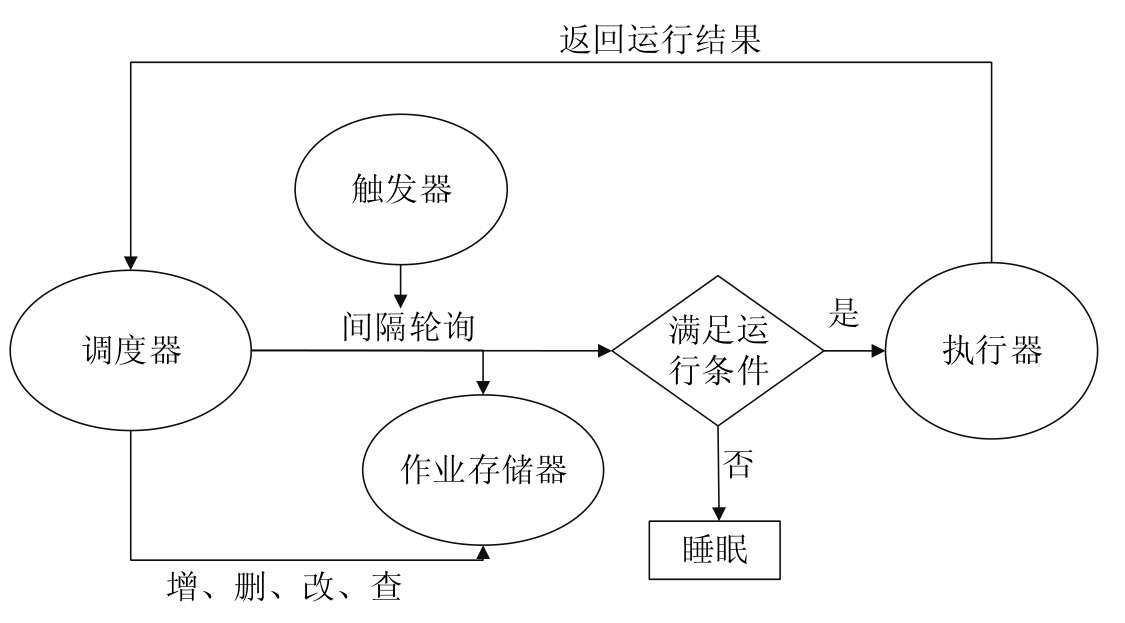

##### （3）基本用法：一个简单的间隔任务调度器

In [12]:
# 导入必需的模块
from datetime import datetime
import os
from apscheduler.schedulers.blocking import BlockingScheduler

In [13]:
# 定义任务
def task():
    print("Tick! Current Time is: {0}".format(datetime.now()))

In [14]:
# 调度并执行任务
scheduler = BlockingScheduler() # 创建任务调度器
scheduler.add_job(task, 'interval', seconds=2) # 添加每隔2秒执行一次的任务
print('按 "Ctrl+{0}" 退出.'.format('Break' if os.name == 'nt' else 'C'))

try:
    scheduler.start()
except (KeyboardInterrupt, SystemExit):
    print('中断退出！')
    

按 "Ctrl+C" 退出.
Tick! Current Time is: 2020-07-28 08:01:51.261374
Tick! Current Time is: 2020-07-28 08:01:53.265979
Tick! Current Time is: 2020-07-28 08:01:55.264940
Tick! Current Time is: 2020-07-28 08:01:57.266789
Tick! Current Time is: 2020-07-28 08:01:59.266795
Tick! Current Time is: 2020-07-28 08:02:01.262150
中断退出！


在配置调度器之前，首先需要选择适合应用场景的调度器、存储器和执行器。下面是各调度器的使用场景：

- **BlockingScheduler**: 即阻塞型调度器，调用start函数会阻塞当前线程，不能立即返回。
- **BackgroundScheduler**: 即后台（非阻塞）调度器，调用start后主线程不会阻塞，立即返回。
- **AsyncIOScheduler**: 即异步IO调度器，适用于基于asyncio模块的应用程序，不常用。
- **GeventScheduler**: 即事件调度器，适用于基于gevent模块的应用程序，不常用。
- **TwistedScheduler**: 即绞合调度器，适用于构建Twisted应用程序，不常用。
- **QtScheduler**: 即QT调度器，适用于构建基于Qt的GUI应用程序。

##### （4）高级用法：使用数据库作为作业存储器的任务调度器

In [15]:
# 导入必需的模块
from apscheduler.schedulers.blocking import BlockingScheduler
from datetime import datetime, timedelta
from apscheduler.jobstores.sqlalchemy import SQLAlchemyJobStore
from apscheduler.executors.pool import ThreadPoolExecutor, ProcessPoolExecutor
from apscheduler.events import EVENT_JOB_EXECUTED, EVENT_JOB_ERROR
# 日志模块
import logging

In [16]:
# 配置日志
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s %(filename)s[line:%(lineno)d]%(levelname)s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    filename='logs.txt',
                    filemode='a')

In [17]:
# 定义工作任务
def my_job(id = 'my job'):
    print(id, '-->', datetime.now())

def err_job(id = 'error job'):
    print(id, '-->', datetime.now().strftime('%Y-%m-%d %H:%M:%S'), id)
    print(1/0) # 除零错误

In [18]:
# 定义事件监听器
def event_listener(event):
    if event.exception:
        print('任务执行错误：', event.exception)
    else:
        print('任务正在运行...')

In [19]:
# 配置作业存储器
jobstores = {
    # 名为default,使用SQLite的SQLAlchemy作业存储器
    'default': SQLAlchemyJobStore(url='sqlite:///jobs.sqlite')
}
# 配置执行器
executors = {
    # 名为default，最大线程数为20的线程池执行器
    'default': ThreadPoolExecutor(20),
    # 名为processpool,最大进程数为5的进程池执行器
    'processpool': ProcessPoolExecutor(10)
}
# 默认工作任务
job_defaults = {
    'coalesce': False, # 关闭coalesce（联合）函数
    'max_instances': 3 # 作业的默认最大运行实例数为3
}

In [20]:
# 创建并配置任务调度器
scheduler = BlockingScheduler(jobstores=jobstores, executors=executors,job_defaults=job_defaults)

In [21]:
# 添加间隔型(interval)工作任务
scheduler.add_job(my_job, args=['Job Interval',], id='job_interval', trigger='interval', 
                  seconds=2, replace_existing=True)
# 添加计划型(cron）工作任务
scheduler.add_job(my_job, args=['Job Cron',], id='job_cron', trigger='cron', 
                  month='1-12', hour='0-23', second='*/5', end_date='2020-07-20',replace_existing=True)
# 添加定时(date once)工作任务
scheduler.add_job(my_job, args=['Job Date Once',], id='job_date_once', trigger='date', 
                  run_date='2020-07-20 20:00:00', replace_existing=True)

<Job (id=job_date_once name=my_job)>

In [22]:
# 添加一次性任务
scheduler.add_job(func=err_job, args=['会出错的一次性任务',], 
                  next_run_time=datetime.now() + timedelta(seconds=15),
                  id='error_task')

<Job (id=error_task name=err_job)>

In [23]:
# 添加事件监听器
scheduler.add_listener(event_listener, EVENT_JOB_EXECUTED | EVENT_JOB_ERROR)

In [24]:
# 设置日志
scheduler._logger = logging

In [25]:
# 启动调度器
try:
    scheduler.start()
except (KeyboardInterrupt, SystemExit):
    print('Exit!')
    exit()

Job Interval --> 2020-07-28 08:02:25.973351
任务正在运行...
Job Interval --> 2020-07-28 08:02:27.983384
任务正在运行...
Job Interval --> 2020-07-28 08:02:29.981382
任务正在运行...
Job Interval --> 2020-07-28 08:02:31.983043
任务正在运行...
Job Interval --> 2020-07-28 08:02:33.978473
任务正在运行...
会出错的一次性任务 --> 2020-07-28 08:02:34 会出错的一次性任务
任务执行错误： division by zero
Job Interval --> 2020-07-28 08:02:35.985781
任务正在运行...
Exit!


#### psutil的使用

运维离不开对系统信息的监控，如CPU的使用率、内存的占用情况、网络、进程等相关信息都需要被监控。虽然可以通过Paramiko模块远程执行linux命令获取系统信息，但由于其返回的结果格式都是非结构化文本，处理起来并不方便。Python中获取系统信息更便捷的模块是psutil(Prcess and system utilities）。

##### （1）安装psutil

In [1]:
!pip install psutil -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Processing ./.cache/pip/wheels/e3/72/85/6a3b939dee2c748c4b47b8a428acc2d07f3560c1bb8d447714/psutil-5.7.2-cp38-cp38-linux_x86_64.whl


In [2]:
!pip show psutil

Name: psutil
Version: 5.7.2
Summary: Cross-platform lib for process and system monitoring in Python.
Home-page: https://github.com/giampaolo/psutil
Author: Giampaolo Rodola
Author-email: g.rodola@gmail.com
License: BSD
Location: /opt/conda/lib/python3.8/site-packages
Requires: 
Required-by: 


##### (2) 基本用法(本地）

- 监控CPU信息

In [3]:
import psutil

# 获取CPU占用时间的详细信息
psutil.cpu_times()

scputimes(user=3107.6, nice=0.0, system=4268.39, idle=216523.09, iowait=61.97, irq=0.0, softirq=124.68, steal=0.0, guest=0.0, guest_nice=0.0)

In [4]:
# 获取每个CPU占用时间的详细信息
psutil.cpu_times(percpu=True)

[scputimes(user=1543.32, nice=0.0, system=2134.26, idle=108065.99, iowait=30.84, irq=0.0, softirq=70.05, steal=0.0, guest=0.0, guest_nice=0.0),
 scputimes(user=1564.3, nice=0.0, system=2134.16, idle=108457.92, iowait=31.13, irq=0.0, softirq=54.63, steal=0.0, guest=0.0, guest_nice=0.0)]

In [5]:
# CPU逻辑数量
psutil.cpu_count()

2

In [6]:
# CPU物理数量
psutil.cpu_count(logical=False)

1

In [7]:
# CPU使用百分比
psutil.cpu_percent()

4.5

In [8]:
# 每个CPU(核）的占比
psutil.cpu_percent(percpu=True)

[4.7, 3.5]

- 监控内存信息

In [9]:
mem_info = psutil.virtual_memory()
mem_info

svmem(total=2088206336, available=1605758976, percent=23.1, used=320225280, free=338309120, active=621129728, inactive=832102400, buffers=235057152, cached=1194614784, shared=581632, slab=261951488)

In [10]:
mem_info.total/(1024 * 1024)

1991.46875

- 监控磁盘信息

In [11]:
# 分区信息
psutil.disk_partitions()

[sdiskpart(device='/dev/vda1', mountpoint='/etc/resolv.conf', fstype='ext4', opts='rw,relatime'),
 sdiskpart(device='/dev/vda1', mountpoint='/etc/hostname', fstype='ext4', opts='rw,relatime'),
 sdiskpart(device='/dev/vda1', mountpoint='/etc/hosts', fstype='ext4', opts='rw,relatime')]

In [12]:
# 使用情况
psutil.disk_usage('/')

sdiskusage(total=62725623808, used=12582248448, free=46926659584, percent=21.1)

In [13]:
# IO计数
psutil.disk_io_counters()

sdiskio(read_count=148536, write_count=176207, read_bytes=2625571840, write_bytes=6444417024, read_time=108903, write_time=198356, read_merged_count=26627, write_merged_count=687152, busy_time=86518)

- 监控网络信息

In [14]:
# 获取网络流量（IO字节数）
psutil.net_io_counters()

snetio(bytes_sent=4545572, bytes_recv=30013416, packets_sent=10443, packets_recv=24640, errin=0, errout=0, dropin=0, dropout=0)

In [15]:
# 获取网络接口信息
psutil.net_if_addrs()

{'lo': [snicaddr(family=<AddressFamily.AF_INET: 2>, address='127.0.0.1', netmask='255.0.0.0', broadcast=None, ptp=None),
  snicaddr(family=<AddressFamily.AF_PACKET: 17>, address='00:00:00:00:00:00', netmask=None, broadcast=None, ptp=None)],
 'eth0': [snicaddr(family=<AddressFamily.AF_INET: 2>, address='172.24.0.4', netmask='255.255.0.0', broadcast='172.24.255.255', ptp=None),
  snicaddr(family=<AddressFamily.AF_PACKET: 17>, address='02:42:ac:18:00:04', netmask=None, broadcast='ff:ff:ff:ff:ff:ff', ptp=None)],
 'tunl0': [snicaddr(family=<AddressFamily.AF_PACKET: 17>, address='00:00:00:00:00:00', netmask=None, broadcast=None, ptp=None)],
 'ip6tnl0': [snicaddr(family=<AddressFamily.AF_PACKET: 17>, address='00:00:00:00:00:00:00:00:00:00:00:00:00:00:00:00', netmask=None, broadcast=None, ptp=None)]}

In [16]:
# 获取网络接口状态
psutil.net_if_stats()

{'eth0': snicstats(isup=True, duplex=<NicDuplex.NIC_DUPLEX_FULL: 2>, speed=10000, mtu=1500),
 'ip6tnl0': snicstats(isup=False, duplex=<NicDuplex.NIC_DUPLEX_UNKNOWN: 0>, speed=0, mtu=1452),
 'lo': snicstats(isup=True, duplex=<NicDuplex.NIC_DUPLEX_UNKNOWN: 0>, speed=0, mtu=65536),
 'tunl0': snicstats(isup=False, duplex=<NicDuplex.NIC_DUPLEX_UNKNOWN: 0>, speed=0, mtu=1480)}

In [17]:
# 获取网络连接信息
psutil.net_connections()

[sconn(fd=-1, family=<AddressFamily.AF_INET: 2>, type=<SocketKind.SOCK_STREAM: 1>, laddr=addr(ip='127.0.0.1', port=55227), raddr=addr(ip='127.0.0.1', port=37814), status='TIME_WAIT', pid=None),
 sconn(fd=-1, family=<AddressFamily.AF_INET: 2>, type=<SocketKind.SOCK_STREAM: 1>, laddr=addr(ip='172.24.0.4', port=54230), raddr=addr(ip='183.3.225.42', port=465), status='TIME_WAIT', pid=None),
 sconn(fd=35, family=<AddressFamily.AF_INET: 2>, type=<SocketKind.SOCK_STREAM: 1>, laddr=addr(ip='172.24.0.4', port=8888), raddr=addr(ip='172.24.0.1', port=38126), status='ESTABLISHED', pid=21),
 sconn(fd=41, family=<AddressFamily.AF_INET: 2>, type=<SocketKind.SOCK_STREAM: 1>, laddr=addr(ip='127.0.0.1', port=40015), raddr=addr(ip='127.0.0.1', port=33898), status='ESTABLISHED', pid=876),
 sconn(fd=13, family=<AddressFamily.AF_INET: 2>, type=<SocketKind.SOCK_STREAM: 1>, laddr=addr(ip='172.24.0.4', port=8888), raddr=addr(ip='172.24.0.1', port=38060), status='ESTABLISHED', pid=21),
 sconn(fd=32, family=<Add

In [18]:
# 获取进程ID
psutil.pids()

[1, 6, 21, 75, 859, 876]

In [19]:
# 获取进程信息
[ps for ps in psutil.process_iter()]

[psutil.Process(pid=1, name='tini', status='sleeping', started='07:48:12'),
 psutil.Process(pid=6, name='sudo', status='sleeping', started='07:48:13'),
 psutil.Process(pid=21, name='jupyter-lab', status='running', started='07:48:13'),
 psutil.Process(pid=75, name='bash', status='sleeping', started='07:48:39'),
 psutil.Process(pid=859, name='ssh', status='sleeping', started='07:56:16'),
 psutil.Process(pid=876, name='python', status='running', started='08:02:38')]

In [20]:
# 获取特定进程的信息
print('CPU占用:', psutil.Process(21).cpu_times())
print('内存占用:',psutil.Process(21).memory_info())
print('线程数:',psutil.Process(21).num_threads())

CPU占用: pcputimes(user=6.05, system=2.07, children_user=10.08, children_system=3.28, iowait=0.21)
内存占用: pmem(rss=67444736, vms=300810240, shared=16314368, text=2441216, lib=0, data=76201984, dirty=0)
线程数: 4


##### （3）psutil远程监控

使用psutil进行远程监控并不方便，因为需要在被监控的主机上通过pip安装psutil，并且通过Paramiko远程执行监控脚本。如果依次在每台被监控的远程主机上手工安装psutil模块则违背了自动化运维的初衷,这就需要用到大名鼎鼎的自动化配置管理工具：Ansible。关于ansible的详细用法，放在“高级“部分介绍。这里先给出远程监控代码的实现以及如何使用ansible在远程主机上安装psutil。

- 使用ansible在远程主机上安装psutil

In [1]:
# 安装ansible
!pip install ansible -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Processing ./.cache/pip/wheels/67/f3/8c/37a49e73a7ce88c865b211efb3f95e34baed377d1791d7f1d5/ansible-2.9.11-py3-none-any.whl
Processing ./.cache/pip/wheels/48/24/08/d0184c47f10952e1005f5ee0662dad967372fe33c1cea7297b/PyYAML-5.3.1-cp38-cp38-linux_x86_64.whl


In [2]:
# 查看ansible的版本信息
!ansible --version

ansible 2.9.11
  config file = /home/admin/ansible.cfg
  configured module search path = ['/home/admin/.ansible/plugins/modules', '/usr/share/ansible/plugins/modules']
  ansible python module location = /opt/conda/lib/python3.8/site-packages/ansible
  executable location = /opt/conda/bin/ansible
  python version = 3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) [GCC 7.5.0]


In [7]:
# 配置 ansible
!cat ansible.cfg

[defaults]
inventory = inventory

remote_user = root
remote_port = 22

timeout = 100

host_key_checking = False
private_key_file = ~/.ssh/id_rsa

log_path=ansible.log
retry_files_save_path = ./ansible-retry

action_warnings = False
command_warnings = False

In [8]:
# 配置资产库inventory
!cat inventory

[servers]
node-ubuntu  ansible_ssh_host=node-ubuntu  ansible_ssh_port=22
node-debian  ansible_ssh_host=node-debian  ansible_ssh_port=22
node-centos  ansible_ssh_host=node-centos  ansible_ssh_port=22

In [70]:
# 使用ansible测试远程连接
!ansible all -m ping -c paramiko

node-ubuntu | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong",
    "warnings": [
        "Platform linux on host node-ubuntu is using the discovered Python interpreter at /usr/bin/python, but future installation of another Python interpreter could change this. See https://docs.ansible.com/ansible/2.9/reference_appendices/interpreter_discovery.html for more information."
    ]
}
node-debian | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong",
    "warnings": [
        "Platform linux on host node-debian is using the discovered Python interpreter at /usr/bin/python, but future installation of another Python interpreter could change this. See https://docs.ansible.com/ansible/2.9/reference_appendices/interpreter_discovery.html for more information."
    ]
}
node-centos | SUCCESS => {
    "ansible_facts": 

In [22]:
# 使用国内apt镜像源
!ansible node-debian -m copy -a "src=/etc/apt/sources.list dest=/etc/apt/sources.list" -c paramiko -become --become-user root

node-debian | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "checksum": "c04c4466c4366da0045731672fe093783a595203",
    "dest": "/etc/apt/sources.list",
    "gid": 0,
    "group": "root",
    "md5sum": "a081e9374d9c9fc73c705b8b8c796c56",
    "mode": "0644",
    "owner": "root",
    "size": 1141,
    "src": "/home/docker/.ansible/tmp/ansible-tmp-1595930433.9043386-1305-1475965460238/source",
    "state": "file",
    "uid": 0,
    "warnings": [
        "Platform linux on host node-debian is using the discovered Python interpreter at /usr/bin/python, but future installation of another Python interpreter could change this. See https://docs.ansible.com/ansible/2.9/reference_appendices/interpreter_discovery.html for more information."
    ]
}


【失败原因】默认不支持密码登录，需要安装sshpass才行。建议使用公钥认证方式登录。使用ssh-keygen生成密钥的过程需要交互，需在终端执行，并修改inventory文件，取消密码（删除ansible_ssh_pass=docker项）登录。

In [81]:
# 查看生成的公钥
!cat ~/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABgQDA21XNUxeBIEsbH07+pP499KqAha5CARzEfcIRJfVvTP6KDqUpFcqT8izSJDBb2gsUvdxnhRChyQVUy0kSn3C0+JrUSDCxZEOaL+qeCGkj6UpfC++iU0cKa7dHjfpJUdGJ5KG2+/L6VBCUipsUQMCWbm7vs5OjG/qWR6omh45BKcQeHPvTh3qZx8TYgv1I7stqU0Cnj3S3uQSLw4S8j+P5+ePL4lCPXufIhmlY6SX0vinSeo75fD58Bng/y7/zbCrK5SFKNNBpC3EefGK+ewFMAzEff0mYXDLAiBpTnSVUDk9JrhUaL+ai5y/BJ+NFBLqniChNil3JkzWmGKoi6FMZLjYI9FAeWro51I/6r1Bcct6Za3c1q8KDWWRM405XZ+gqhM7vWRrlrq4pXe6Onu8V/oQBZbKPi/bf23yW53DeXH/EkwW2MB9HNglS/+CQt+0VEJuCIITl6XQ5MT9GiRl72V1XrhDRjQNsv2rPjTdHbG/Hst+/pkeTQVWV71BQXAE= admin@node-jupyter


In [82]:
# 查看修改后的inventory文件
!cat inventory

server1  ansible_ssh_host=node-ubuntu  ansible_ssh_port=22
server2  ansible_ssh_host=node-debian  ansible_ssh_port=22
server3  ansible_ssh_host=node-centos  ansible_ssh_port=22

In [29]:
# 使用ansible再次测试远程连接
!ansible all -m ping -c paramiko

node-debian | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong",
    "warnings": [
        "Platform linux on host node-debian is using the discovered Python interpreter at /usr/bin/python, but future installation of another Python interpreter could change this. See https://docs.ansible.com/ansible/2.9/reference_appendices/interpreter_discovery.html for more information."
    ]
}
node-ubuntu | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong",
    "warnings": [
        "Platform linux on host node-ubuntu is using the discovered Python interpreter at /usr/bin/python, but future installation of another Python interpreter could change this. See https://docs.ansible.com/ansible/2.9/reference_appendices/interpreter_discovery.html for more information."
    ]
}
node-centos | SUCCESS => {
    "ansible_facts": 

【失败原因】未下发公钥到远程（被控）主机。使用密钥拷贝工具ssh-copy-id把公钥拷贝到被控节点，由于公钥拷贝过程需要交互（输入密码），需在终端执行。

In [97]:
# 使用ansible再次测试远程连接
!ansible all -m ping -c paramiko

server2 | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong",
    "warnings": [
        "Platform linux on host server2 is using the discovered Python interpreter at /usr/bin/python, but future installation of another Python interpreter could change this. See https://docs.ansible.com/ansible/2.9/reference_appendices/interpreter_discovery.html for more information."
    ]
}
server1 | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong",
    "warnings": [
        "Platform linux on host server1 is using the discovered Python interpreter at /usr/bin/python, but future installation of another Python interpreter could change this. See https://docs.ansible.com/ansible/2.9/reference_appendices/interpreter_discovery.html for more information."
    ]
}
server3 | SUCCESS => {
    "ansible_facts": {
        "discovere

In [99]:
# 切换到sudo执行命令
!ansible servers -m ping -c paramiko -u docker --become-user root

server2 | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong",
    "warnings": [
        "Platform linux on host server2 is using the discovered Python interpreter at /usr/bin/python, but future installation of another Python interpreter could change this. See https://docs.ansible.com/ansible/2.9/reference_appendices/interpreter_discovery.html for more information."
    ]
}
server1 | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong",
    "warnings": [
        "Platform linux on host server1 is using the discovered Python interpreter at /usr/bin/python, but future installation of another Python interpreter could change this. See https://docs.ansible.com/ansible/2.9/reference_appendices/interpreter_discovery.html for more information."
    ]
}
server3 | SUCCESS => {
    "ansible_facts": {
        "discovere

In [104]:
# 检查playbook语法
!ansible-playbook playbook.yml --syntax-check


playbook: playbook.yml


In [114]:
# 下载yum国内镜像源
!wget -O CentOS-Base.repo http://mirrors.aliyun.com/repo/Centos-7.repo

--2020-07-27 14:45:56--  http://mirrors.aliyun.com/repo/Centos-7.repo
Resolving mirrors.aliyun.com (mirrors.aliyun.com)... 1.71.146.238, 1.71.146.242, 1.71.146.240, ...
Connecting to mirrors.aliyun.com (mirrors.aliyun.com)|1.71.146.238|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2523 (2.5K) [application/octet-stream]
Saving to: ‘CentOS-Base.repo’

CentOS-Base.repo    100%[===================>]   2.46K  --.-KB/s    in 0s      

2020-07-27 14:45:56 (44.4 MB/s) - ‘CentOS-Base.repo’ saved [2523/2523]



In [27]:
# 执行playbook
!ansible-playbook playbook.yml -c paramiko -u docker -become --become-user root


PLAY [安装 psutil 模块] ************************************************************

TASK [Gathering Facts] *********************************************************
ok: [node-ubuntu]
ok: [node-centos]
ok: [node-debian]

TASK [分发get-pip.py安装脚本] ********************************************************
ok: [node-ubuntu]
ok: [node-centos]
ok: [node-debian]

TASK [运行get-pip.py安装脚本] ********************************************************
changed: [node-debian]
changed: [node-centos]
changed: [node-ubuntu]

TASK [复制sources.list到debian和ubuntu] ********************************************
skipping: [node-centos]
ok: [node-ubuntu]
ok: [node-debian]

TASK [更新apt源] ******************************************************************
skipping: [node-centos]
changed: [node-ubuntu]
changed: [node-debian]

TASK [apt安装gcc和python-dev] *****************************************************
skipping: [node-centos]
changed: [node-ubuntu]
changed: [node-debian]

TASK [复制CentOS-Base.repo到centos] ***************

- 远程主机（被监控机）上执行的脚本

In [28]:
!cat rc.sh

python <<EOF
import json
import psutil as pu
memInfo = {}
mem = pu.virtual_memory()
memInfo["total"] = mem.total
memInfo["available"] = mem.available
memInfo["percent"] = mem.percent
memInfo["used"] = mem.used
memInfo["free"] = mem.free
data = json.dumps(memInfo)
print(data)
EOF


- 本地（监控机）上执行的脚本

In [35]:
import paramiko
import os
import json
 
##读取当前路径
base_dir = os.getcwd()
##读取在远程主机执行的脚本
cmd_filepath = base_dir + r"/rc.sh"
cmd_file = open(cmd_filepath,"r")
cmd = cmd_file.read()
# cmd = 'python --version'
##连接远程主机
client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

for server_cfg in server_cfgs:
    # 连接服务器
    client.connect(server_cfg['name'], 22, 
                   username=server_cfg['username'], 
                   password=server_cfg['password'], 
                   timeout=4)
    # 远程执行shell命令
    stdin, stdout, stderr = client.exec_command(cmd)
    # 输出远程服务器shell命令的输出
    stdout_str = stdout.read().decode('utf-8')
    # 获取返回的状态码
    ret_code = stdout.channel.recv_exit_status()
    print("****************** {},状态码：{} *****************\n{}".format(server_cfg['name'], ret_code, stdout_str))
    # 关闭连接
    client.close()

****************** node-ubuntu,状态码：0 *****************
{"available": 1411584000, "total": 2088206336, "percent": 32.4, "free": 362975232, "used": 492064768}

****************** node-debian,状态码：0 *****************
{"available": 1411837952, "total": 2088206336, "percent": 32.4, "free": 363216896, "used": 491806720}

****************** node-centos,状态码：0 *****************
{"available": 1410277376, "total": 2088206336, "percent": 32.5, "free": 361652224, "used": 493371392}



### 1.5 NodeMonitor项目的OOP实现【过程演示】

In [38]:
!tree node-monitor

node-monitor
└── app.py

0 directories, 1 file
